In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm

In [ ]:
import os
import jsonlines
from tqdm import tqdm

save_names = ['llava_pretrain']
data = {name: [] for name in save_names}
file_path = '/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/alignment_2.5m.jsonl'
base_path = '/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment'

# Count the total number of lines for the progress bar
total_lines = sum(1 for _ in open(file_path))

with jsonlines.open(file_path) as reader:
    for entry in tqdm(reader, total=total_lines, desc="Processing entries"):
        data_split = entry['image'].split('/')[1]
        
        if data_split in save_names:
            if data_split == 'llava_pretrain':
                entry['image'] = entry['image'].replace('llava_pretrain/images', 'sbu558k')
            image_path = os.path.join(base_path, entry['image'])
            image_path = os.path.normpath(image_path)
            
            if os.path.exists(image_path):
                data[data_split].append(entry)
            else:
                break
# count the number of each dataset
for key, entries in data.items():
    print(f"{key}: {len(entries)}")


/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/sbu558k/00120/001200924.jpg

In [ ]:
# save as json for each data
for key, entries in data.items():
    save_path = f'/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/{key}.json'
    with open(save_path, 'w') as f:
        json.dump(entries, f)
    print(f"Saved {len(entries)} entries to {save_path}")

In [ ]:
import torch
from tqdm import tqdm
def get_linear_input(sequence_output):
    cls_token = sequence_output[:, 0]
    patch_tokens = sequence_output[:, 1:]
    linear_input = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1)
    return linear_input
directory = '/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-base'
for filename in os.listdir(directory):
    if filename.endswith(".pt"):
        print(os.path.join(directory, filename))
        image_embedding = torch.load(os.path.join(directory, filename))
        image_embedding = get_linear_input(image_embedding)
        torch.save(image_embedding, os.path.join(directory, filename))
    else:
        continue

In [ ]:
import glob
import os
from natsort import natsorted
path_list = ['/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-large/ALLaVAVFLAN', '/home/mila/l/le.zhang/scratch/light_align/data/image_embedding/dinov2-large/LLaVA558K']
all_files = []
for dir_path in path_list:
    files = glob.glob(os.path.join(dir_path, "*.pt"))
    sorted_files = natsorted(files)
    all_files.extend(sorted_files)
all_files

In [ ]:
import os
import json
# read json
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/llava_pretrain.json', 'r') as f:
    sharegpt4v = json.load(f)
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/sbu558k.json', 'r') as f:
    sbu558k = json.load(f)
with open('/home/mila/l/le.zhang/scratch/datasets/Cambrian-Alignment/jsons/coco.json', 'r') as f:
    coco = json.load(f)




In [ ]:
# function to caculate avg length 
def avg_length(data):
    avg = 0
    for entry in data:
        avg += len(entry['conversations'][-1]['value'])
    return avg/len(data)

avg_length(sharegpt4v), avg_length(sbu558k), avg_length(coco)

In [ ]:
sharegpt4v[0]

In [ ]:
import os
import torch
from natsort import natsorted
import glob

def merge_pt_files(directory):
    # 获取所有的 .pt 文件路径，并按名字顺序排序
    files = glob.glob(os.path.join(directory, "*.pt"))
    files = natsorted(files)
    
    # 确保文件数量为偶数
    if len(files) % 2 != 0:
        raise ValueError("The number of .pt files is not even. Please make sure the files can be paired.")

    # 遍历所有文件，按两个为一组进行合并
    for i in range(0, len(files), 2):
        file1 = files[i]
        file2 = files[i+1]
        
        # 加载两个文件
        tensor1 = torch.load(file1)
        tensor2 = torch.load(file2)
        
        # 在第一个维度进行拼接
        merged_tensor = torch.cat((tensor1, tensor2), dim=0)
        
        # 生成新文件名
        base_name1 = os.path.basename(file1).replace(".pt", "")
        base_name2 = os.path.basename(file2).replace(".pt", "")
        new_file_name = f"{base_name1}_{base_name2}.pt"
        new_file_path = os.path.join(directory, new_file_name)
        
        # 保存拼接后的tensor
        torch.save(merged_tensor, new_file_path)
        print(f"Saved merged tensor to {new_file_path}")

# 示例用法
# merge_pt_files('/path/to/your/directory')


In [ ]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/laion30m_caption"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 4096:
        print(file, tensor.size(0))
print(total_len)



## 1.3 check if the image  is correct

In [2]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-Qwen2-7B-instruct/dreamclipcc3m_raw_caption"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 1024:
        print(file, tensor.size(0))
print(total_len)



  0%|          | 0/2186 [00:00<?, ?it/s]

100%|██████████| 2186/2186 [00:56<00:00, 38.63it/s]

/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-Qwen2-7B-instruct/dreamclipcc3m_raw_caption/2185.pt 633
2238073


In [4]:
import os
import glob
import torch
from tqdm import tqdm
file_dir = "/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat"
files = glob.glob(os.path.join(file_dir, "*.pt"))
total_len = 0
for file in tqdm(files):
    tensor = torch.load(file, map_location=torch.device('cpu'), weights_only=False)
    total_len += tensor.size(0)
    if tensor.size(0) != 2048:
        print(file, tensor.size(0))
    if tensor.size(1) != 2048:
        print(file, tensor.size(1))
print(total_len)



  1%|          | 13/1093 [00:00<00:16, 63.75it/s]

/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat/0.pt 6144
/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat/1.pt 6144
/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat/2.pt 6144
/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat/3.pt 6144


100%|██████████| 1093/1093 [00:23<00:00, 46.46it/s]

/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m_concat/1092.pt 1657
2254457


# 3: test if embedding are encoded correctly

In [1]:
import pandas as pd
import random
import os
from data_config import DATADIR
# csv = pd.read_csv('/home/mila/l/le.zhang/scratch/datasets/LAION/30M_laion_synthetic_filtered_large_with_path_filtered.csv')
# csv = pd.read_csv(DATADIR['laion30m']['annotation'])
# csv = pd.read_csv(DATADIR['dreamclipcc12mhf']['annotation'])
csv = pd.read_csv(DATADIR['dreamclipcc3m']['annotation'])
csv

,Image Path,raw_caption,longIB_captions,longSV_captions,longLLA_captions
0,CC3M/images/0000000/0000000.jpg,how to build an industry for dollars,"In the image, there is a small black house wit...",The image captures a tranquil scene in a woode...,The image features a small wooden cabin with a...
1,CC3M/images/0000000/0000002.jpg,animation of globe and graph .,"In the image, there are several objectively ex...",The image presents a captivating view of our p...,animation of globe and graph .
2,CC3M/images/0000000/0000004.jpg,travelling in style : actor was dressed to imp...,"In the image, there are several visible object...","In the image, a man is the central figure, wal...",The image features a man walking down a hallwa...
3,CC3M/images/0000000/0000005.jpg,players knelt in protest during the national a...,"In the image, a group of football players from...",The image captures a poignant moment on a foot...,The image features a group of football players...
4,CC3M/images/0000000/0000006.jpg,young man giving a present to young woman at r...,"In the image, a man and a woman are sitting at...","In the image, a man and a woman are seated at ...",The image features a man and a woman sitting a...
...,...,...,...,...,...
2238068,CC3M/images/0188651/0000009.jpg,"mum , there 's another baby in the room .","In the image, there is a woman wearing a pink ...","In the image, a woman is seen sitting on a hos...",The image features a woman sitting in a hospit...
2238069,CC3M/images/0188651/0000011.jpg,vector illustration in a flat style of group o...,"In the picture, there are various people of di...",vector illustration in a flat style of group o...,The image is a colorful collage of various peo...
2238070,CC3M/images/0188651/0000012.jpg,worried man sitting in the restaurant and eati...,"In the image, there is a man wearing glasses s...","In the image, a man is seated at a table in a ...",The image features a man sitting at a dining t...
2238071,CC3M/images/0188651/0000014.jpg,"stylish floral mandala , element for design .","In the image, there are several visible and ob...",The image presents a captivating digital illus...,The image features a beautifully designed orna...


### 3.1 compare text local embedding and online embedding

In [2]:
import torch
import random

import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

model_path = 'Alibaba-NLP/gte-large-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_path)
text_model = AutoModel.from_pretrained(model_path, trust_remote_code=True, torch_dtype=torch.float16).to('cuda')
text_model.eval()

/home/mila/l/le.zhang/.conda/envs/openflamingo/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/mila/l/le.zhang/.conda/envs/openflamingo/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


NewModel(
  (embeddings): NewEmbeddings(
    (word_embeddings): Embedding(30528, 1024, padding_idx=0)
    (rotary_emb): NTKScalingRotaryEmbedding()
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): NewEncoder(
    (layer): ModuleList(
      (0-23): 24 x NewLayer(
        (attention): NewSdpaAttention(
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): NewGatedMLP(
          (up_gate_proj): Linear(in_features=1024, out_features=8192, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=True)
          (act_fn): GELUActivation()
          (hidden_dropout): Dropout(p=0.1, inplace=False)
        )
        (attn_ln): LayerNorm((1024,), eps=1e-12, elementwis

In [17]:
# Requires transformers>=4.36.0

import torch.nn.functional as F
import random

def compare_embeddings(n_tests=20, verbose=False):
    def compute_difference(precomputed, computed):
        return F.mse_loss(precomputed, computed).item()

    differences = []
    all_test_index = []
    tensor_dir = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc3m_longSV"
    num_files = len(os.listdir(tensor_dir))
    print(f"num_files: {num_files}")
    dimension = torch.load(f"{tensor_dir}/0.pt").shape[0]
    print(f"dimension: {dimension}")
    for _ in range(n_tests):
        file_idx = random.randint(0, num_files-1)
        idx = random.randint(0, dimension-1)

        # Load pre-computed embeddings
        try:
            x = torch.load(f'{tensor_dir}/{file_idx}.pt', weights_only=True)
        except:
            continue

        # Get the caption and its pre-computed embedding
        caption = csv.iloc[file_idx*dimension+idx]['longSV_captions']
        precomputed_embedding = x[idx]

        # Compute the embedding on-the-fly for comparison
        with torch.no_grad():
            inputs = tokenizer(caption, max_length=1024, padding=True, truncation=True, return_tensors='pt').to('cuda')
            outputs = text_model(**inputs)
            computed_embedding = outputs.last_hidden_state[:, 0].to(torch.float16)[0].cpu()

        # Compute the difference
        diff = compute_difference(precomputed_embedding, computed_embedding)
        if diff>0.5:
            print(f"remove {file_idx}.pt, with diff {diff}")
            # remove
            # os.remove(f'/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc12mhf_shortSV_captions/{file_idx}.pt')
        differences.append(diff)
        all_test_index.append(file_idx*dimension+idx)
        if verbose:
            print(f"Test {_ + 1}:")
            print(f"Caption: {caption} from index {file_idx*dimension+idx}")
            print(f"Precomputed embedding : {precomputed_embedding}")
            print(f"Computed embedding : {computed_embedding}")
            print(f"Difference (MSE): {diff}\n")

    # Print summary statistics
    print(f"All test index: {all_test_index}")
    print(f"Average difference over {n_tests} tests: {sum(differences) / n_tests}")
    print(f"Max difference: {max(differences)}")
    print(f"Min difference: {min(differences)}")

# Usage example:
compare_embeddings(n_tests=100, verbose=False)


num_files: 2186
dimension: 1024


/tmp/ipykernel_3127721/549030636.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dimension = torch.load(f"{tensor_dir}/0.pt").shape[0]


All test index: [970911, 80321, 246178, 1217428, 495913, 1660000, 2044278, 706449, 313575, 2153842, 747924, 357499, 1140618, 343066, 2194955, 2083589, 469426, 2056504, 1013039, 263392, 969972, 746747, 347743, 1640089, 201306, 1932140, 757194, 860198, 757847, 511283, 847002, 1099435, 243887, 748707, 1518731, 869981, 2219165, 1923602, 2226013, 1663120, 1648390, 1168378, 410179, 1479303, 676531, 608691, 190386, 323876, 1903881, 1125790, 964290, 1762026, 222293, 137370, 1961540, 1420268, 849358, 1975757, 1272066, 2138361, 1932877, 1863279, 1248147, 2073094, 1924303, 711386, 1834484, 1625657, 1328479, 1340790, 1631346, 1461395, 457527, 2226379, 1050693, 2103581, 542735, 252549, 1072950, 1448612, 764756, 1541318, 1195346, 814207, 318078, 1400989, 1630823, 1044589, 1029796, 1960562, 362592, 1183799, 2043495, 2119393, 1828783, 225361, 2122302, 686233, 514809, 423610]
Average difference over 100 tests: 9.567919272512881e-07
Max difference: 1.0920280146820005e-05
Min difference: 4.17472733715840

### 3.2 Test local image embedding and online computed embedding

In [2]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import os
import random
import torch.nn.functional as F
import time

# processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
processor = AutoImageProcessor.from_pretrained('facebook/vit-mae-large')
model = AutoModel.from_pretrained('facebook/vit-mae-large',attn_implementation="sdpa", torch_dtype=torch.float16)
# model = AutoModel.from_pretrained('facebook/dinov2-large')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model = torch.compile(model)
model.eval()

2024-10-13 20:01:44.669976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 20:01:44.681239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 20:01:44.684726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 20:01:44.694027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 20:01:45.893324: W tensorflow/compiler/tf2

ViTMAEModel(
  (embeddings): ViTMAEEmbeddings(
    (patch_embeddings): ViTMAEPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (encoder): ViTMAEEncoder(
    (layer): ModuleList(
      (0-23): 24 x ViTMAELayer(
        (attention): ViTMAESdpaAttention(
          (attention): ViTMAESdpaSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTMAESelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTMAEIntermediate(
          (dense): Linear(in_features=1024, out_features=4096, bias=True)
          (intermediate_act_fn): GELUActivation(

In [5]:
def compare_image_embeddings(data, model,processor,n_tests=5, verbose=False):
    differences = []
    all_test_indices = []
    device = model.device
    tensor_dir = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/vit-mae-large/{data}"
    num_files = len(os.listdir(tensor_dir))
    print(f"num_files: {num_files}")
    dimension = torch.load(f"{tensor_dir}/0.pt").shape[0]
    print(f"dimension: {dimension}")
    for idx in range(n_tests):
        file_idx = random.randint(0, num_files-1)
        idx = random.randint(0, dimension-1)  # Changed to 0-4095 to match the tensor size
        test_index = file_idx * dimension + idx
        all_test_indices.append(test_index)

        # image_path = os.path.join(DATADIR['laion30m']['imagedir'], csv.iloc[test_index]['Image Path'])
        image_path = os.path.join(DATADIR[data]['imagedir'], csv.iloc[test_index]['Image Path'])
        image = Image.open(image_path)
        
        
        if verbose:
            print(f"Test {idx + 1}:")
            print(f"Comparing image at index {test_index}")

        # Load pre-computed embedding
        # emebdding_path = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/laion30m/{file_idx}.pt"
        emebdding_path = f"{tensor_dir}/{file_idx}.pt"
        if not os.path.exists(emebdding_path):
            continue
        x = torch.load(emebdding_path, weights_only=True)
        precomputed_embedding = x[idx].to(device)

        # Compute embedding on-the-fly
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            with torch.no_grad():
                outputs = model(**inputs)
        sequence_output = outputs[0]
        cls_token = sequence_output[:, 0]
        computed_embedding = cls_token.to(torch.float16)[0]
        # patch_tokens = sequence_output[:, 1:]
        # computed_embedding = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1).to(torch.float16)[0]

        # Move embeddings back to CPU for comparison and storage
        precomputed_embedding = precomputed_embedding.cpu()
        computed_embedding = computed_embedding.cpu()

        if verbose:
            print(f"Precomputed embedding: {precomputed_embedding}")
            print(f"Computed embedding: {computed_embedding}")

        # Compute the difference
        diff = F.mse_loss(precomputed_embedding, computed_embedding).item()
        differences.append(diff)
        if diff>1:
            # os.remove(emebdding_path)
            print(f"remove {emebdding_path}, with diff {diff}")
            
        if verbose:
            print(f"Difference (MSE): {diff}\n")

    # Print summary statistics
    print(f"All test indices: {all_test_indices}")
    print(f"Average difference over {n_tests} tests: {sum(differences) / n_tests}")
    print(f"Max difference: {max(differences)}")
    print(f"Min difference: {min(differences)}")

start_time = time.time()
# Usage example:
compare_image_embeddings("dreamclipcc12mhf",model,processor,n_tests=1000, verbose=False)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

num_files: 1880
dimension: 4096


/tmp/ipykernel_3130810/1870178436.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dimension = torch.load(f"{tensor_dir}/0.pt").shape[0]
/tmp/ipykernel_3130810/1870178436

RuntimeError: The size of tensor a (1536) must match the size of tensor b (1024) at non-singleton dimension 0

### 3.2.1 Manually inspect single file

In [ ]:
from PIL import Image
import torch

device = 'cuda'
file_idx = random.randint(0, 5000)
idx = random.randint(0, 4096)  # Changed to 0-4095 to match the tensor size
test_index = file_idx * 4096 + idx

image_path = os.path.join(DATADIR['laion30m']['imagedir'], csv.iloc[test_index]['Image Path'])
image = Image.open(image_path)


# Load pre-computed embedding
emebdding_path = f"/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/laion30m/{file_idx}.pt"

x = torch.load(emebdding_path, weights_only=True)
precomputed_embedding = x[idx].to(device)

# Compute embedding on-the-fly
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)
sequence_output = outputs[0]
cls_token = sequence_output[:, 0]
patch_tokens = sequence_output[:, 1:]
computed_embedding = torch.cat([cls_token, patch_tokens.mean(dim=1)], dim=1).to(torch.float16)[0]

# Move embeddings back to CPU for comparison and storage
precomputed_embedding = precomputed_embedding.cpu()
computed_embedding = computed_embedding.cpu()
print(f"image index {test_index}")
print(f"Precomputed embedding: {precomputed_embedding}")
print(f"Computed embedding: {computed_embedding}")

### 3.3 Visualize the image and its caption

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from data_config import DATADIR
# load csv file
df = pd.read_csv(DATADIR['dreamclipcc12mhf']['annotation'], nrows=100000)




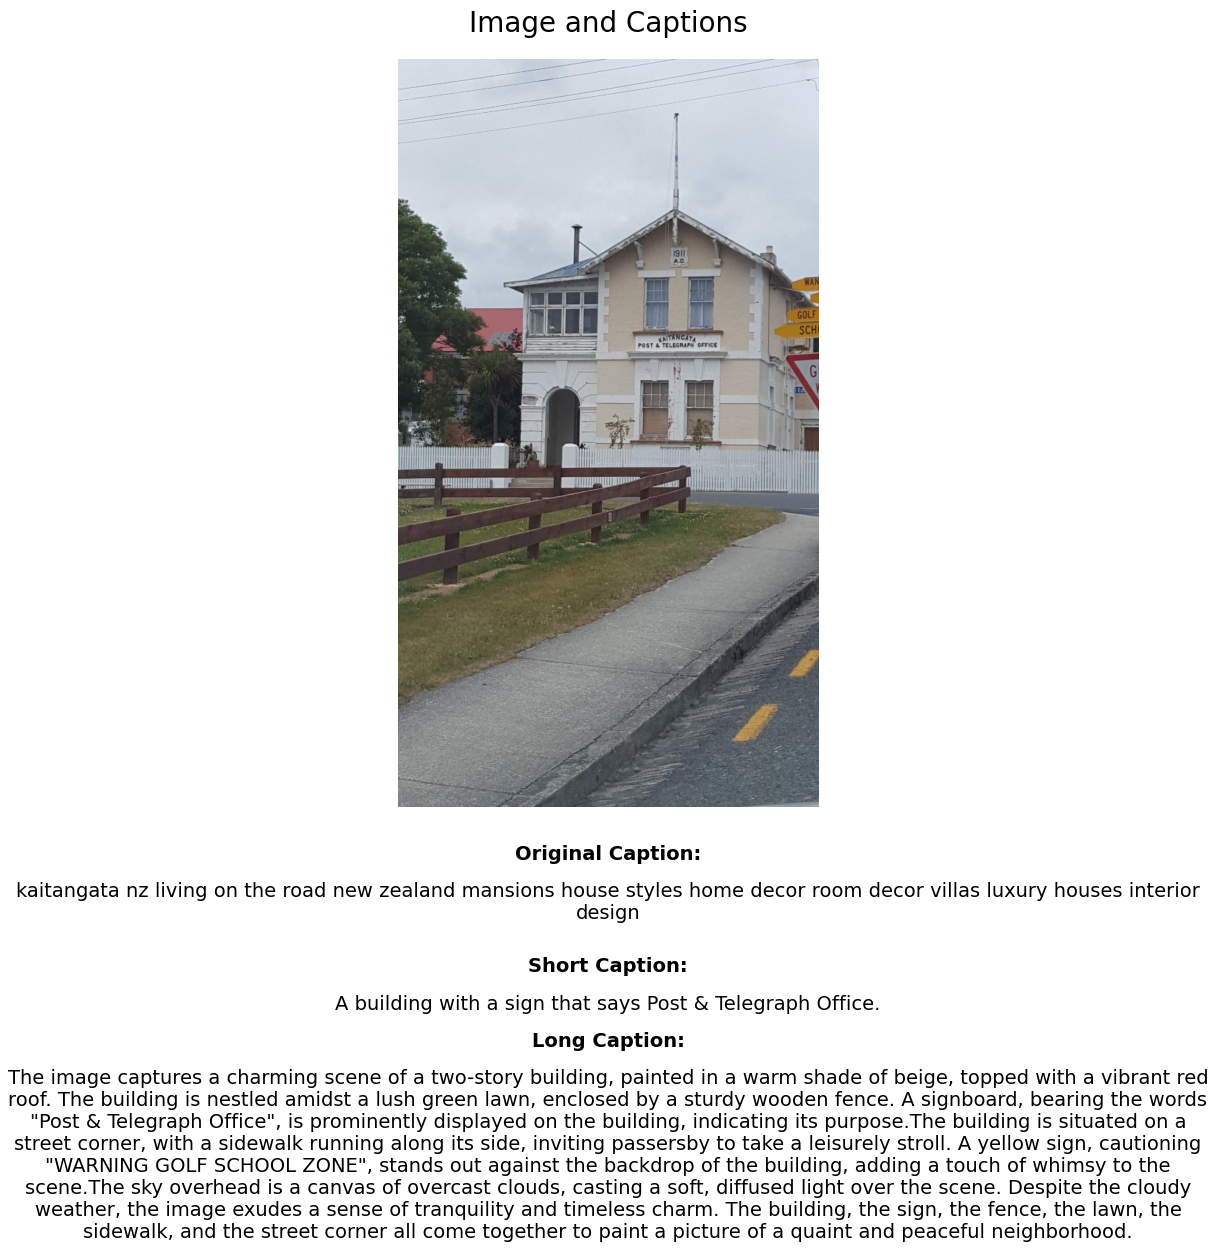

In [18]:
# 获取标题和图像路径
idx = random.randint(0, len(df))
caption = df.iloc[idx]['raw_caption']
short_caption = df.iloc[idx]['shortSV_captions']
long_caption = df.iloc[idx]['longSV_captions']
image_path = os.path.join(DATADIR['dreamclipcc12mhf']['imagedir'], df.iloc[idx]['Image Path'])

# 打开并显示图像
img = Image.open(image_path)
plt.figure(figsize=(12, 14))  # 增加图像大小以容纳更多文本
plt.imshow(img)
plt.axis('off')

# 添加标题和标题
plt.title("Image and Captions", fontsize=20, pad=20)

# 在图像下方添加标题
plt.text(0.5, -0.05, "Original Caption:", fontsize=14, fontweight='bold', 
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)
plt.text(0.5, -0.1, caption, fontsize=14, wrap=True, horizontalalignment='center', 
         verticalalignment='top', transform=plt.gca().transAxes)

plt.text(0.5, -0.2, "Short Caption:", fontsize=14, fontweight='bold', 
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)
plt.text(0.5, -0.25, short_caption, fontsize=14, wrap=True, horizontalalignment='center', 
         verticalalignment='top', transform=plt.gca().transAxes)

plt.text(0.5, -0.3, "Long Caption:", fontsize=14, fontweight='bold', 
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes)
plt.text(0.5, -0.35, long_caption, fontsize=14, wrap=True, horizontalalignment='center', 
         verticalalignment='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig(f"/home/mila/l/le.zhang/scratch/light_align/data/examples/example_{idx}.png")
plt.show()

In [ ]:
import torch 
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from PIL import Image
t1 = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc3m_raw/0.pt').to(torch.float16)
t2 = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/text_embedding/gte-large-en-v1.5/dreamclipcc3m_longSV/0.pt').to(torch.float16)
#similarity
image = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/dinov2-large/dreamclipcc3m/0.pt').to(torch.float16)
t1, t2

In [26]:
with torch.no_grad():
    longSV_captions = tokenizer([csv.iloc[idx]['longSV_captions']], max_length=1024, padding=True, truncation=True, return_tensors='pt').to('cuda')
    print(csv.iloc[idx]['longSV_captions'])
    longSV = text_model(**longSV_captions)
longSV = longSV.last_hidden_state[:, 0].to(torch.float16)[0].cpu().unsqueeze(0)
print(longSV)

The image captures a charming scene of a two-story building, painted in a warm shade of beige, topped with a vibrant red roof. The building is nestled amidst a lush green lawn, enclosed by a sturdy wooden fence. A signboard, bearing the words "Post & Telegraph Office", is prominently displayed on the building, indicating its purpose.The building is situated on a street corner, with a sidewalk running along its side, inviting passersby to take a leisurely stroll. A yellow sign, cautioning "WARNING GOLF SCHOOL ZONE", stands out against the backdrop of the building, adding a touch of whimsy to the scene.The sky overhead is a canvas of overcast clouds, casting a soft, diffused light over the scene. Despite the cloudy weather, the image exudes a sense of tranquility and timeless charm. The building, the sign, the fence, the lawn, the sidewalk, and the street corner all come together to paint a picture of a quaint and peaceful neighborhood.
tensor([[-0.0396,  0.2483, -0.2773,  ...,  1.3154, 

In [27]:
with torch.no_grad():
    raw_captions = tokenizer([csv.iloc[idx]['raw_caption']], max_length=1024, padding=True, truncation=True, return_tensors='pt').to('cuda')
    print(csv.iloc[idx]['raw_caption'])
    raw = text_model(**raw_captions)
raw = raw.last_hidden_state[:, 0].to(torch.float16)[0].cpu().unsqueeze(0)
print(raw)

kaitangata nz living on the road new zealand mansions house styles home decor room decor villas luxury houses interior design
tensor([[-0.3054, -0.3540, -0.6738,  ...,  0.4165, -0.2430, -1.7705]],
       dtype=torch.float16)


In [28]:
with torch.no_grad():
    shortSV_captions = tokenizer([csv.iloc[idx]['shortSV_captions']], max_length=1024, padding=True, truncation=True, return_tensors='pt').to('cuda')
    print(csv.iloc[idx]['shortSV_captions'])
    shortSV = text_model(**shortSV_captions)
shortSV = shortSV.last_hidden_state[:, 0].to(torch.float16)[0].cpu().unsqueeze(0)
print(shortSV)

A building with a sign that says Post & Telegraph Office.
tensor([[-0.6284, -0.8643, -0.3228,  ...,  0.9297, -0.2141, -0.5991]],
       dtype=torch.float16)


In [29]:
# compute the cosine similarity
cos = F.cosine_similarity(longSV, raw, dim=1)
print(cos)

tensor([0.4436], dtype=torch.float16)


In [30]:
# compute the cosine similarity
cos = F.cosine_similarity(longSV, shortSV, dim=1)
print(cos)

tensor([0.6919], dtype=torch.float16)


In [19]:
import torch
tensor = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_embedding/mae-base/dreamclipcc3m/0.pt')
tensor.shape

/tmp/ipykernel_3143536/1355693708.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load('/home/mila/l/le.zhang/scratch/light_align/data/tensor_data/image_e

torch.Size([4096, 768])

In [15]:
from .mae import get_mae_vit

ImportError: attempted relative import with no known parent package